# Metadata Genre Prediction

Wouldn't it be cool if we could predict the genrea of a song just given its metadata? Here, we will try to build a simple linear classifier that looks at some specific song metadata to classify the song into one of 16 popular genres.

## Data
The data used here can be found [here](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip).

Be sure to unzip with 7zip. On mac, `brew install p7zip` then `7za x fma_metadata.zip`.

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.decomposition import PCA

import datetime

In [2]:
# From https://github.com/mdeff/fma/blob/master/utils.py

import ast

def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [3]:
# Load metadata.
tracks = load('fma_metadata/tracks.csv')
genres = load('fma_metadata/genres.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


## Preprocess the Data

#### Tracks
Tracks are split into album, artist, and track components.

Looking at what we have, let's use the following as features: 

album listens, album date created, artist longitude, artist latitude, track interest, track listens, track duration

In [4]:
ipd.display(tracks["album"].head(5))
ipd.display(tracks["artist"].head(5))
ipd.display(tracks["track"].head(5))

,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [5]:
def dateToInt(date):
    return date.timestamp()

In [6]:
switch = {
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    8: 5,
    9: 6,
    10: 7,
    12: 8,
    13: 9,
    14: 10,
    15: 11,
    17: 12,
    20: 13,
    21: 14,
    38: 15,
    1235: 16
}

def oldGenresToNewGenres(g):
    if len(g) == 0:
        return 0
    
    for x in g:
        ret = switch.get(x, 0);
        if ret != 0:
            return ret
    
    return 0

In [7]:
# select out the columns we want
tracks_ = tracks.iloc[:, [1, 7, 21, 23, 37, 41, 43, 46]]

# fill nill longitudes and latitudes, then drop all other NaNs
tracks_ = tracks_[tracks_['album']['listens'] != -1]
tracks_.columns = tracks_.columns.droplevel(-2)
tracks_[['latitude', 'longitude']] = tracks_[['latitude', 'longitude']].fillna(value=0)
tracks_.dropna()

tracks_['date_created'] = tracks_['date_created'].map(dateToInt)

tracks_['genres_all'] = tracks_['genres_all'].map(oldGenresToNewGenres)
tracks_ = tracks_[tracks_['genres_all'] != 0]

labels_ = tracks_['genres_all'] - 1
tracks_ = tracks_.drop(columns=['genres_all'])

ipd.display(tracks_.head(5))
ipd.display(labels_.head(5))

,date_created,listens,latitude,longitude,duration,interest,listens
track_id,,,,,,,
2,1.227664e+09,6073,40.058324,-74.405661,168,4656,1293
3,1.227664e+09,6073,40.058324,-74.405661,237,1470,514
5,1.227664e+09,6073,40.058324,-74.405661,206,1933,1151
10,1.227664e+09,47632,0.000000,0.000000,161,54881,50135
20,1.227664e+09,2710,51.895927,0.891874,311,978,361


track_id
2     13
3     13
5     13
10     6
20    11
Name: genres_all, dtype: int64

#### Genres

There are 1235 total genres. We will only be testing for the top level genres. There are 16 of these. First, let's get them and renumber them, then we need to renumber all the genres for our tracks.

In [8]:
top_genres = genres.copy()[genres['parent'] == 0]

ipd.display(top_genres)

genres_ = ['International', 'Blues', 'Jazz', 'Classical', 'Historic', 'Country', 'Pop', 'Rock', 'Easy Listening', 'Soul-RnB', 'Electronic', 'Folk', 'Spoken', 'Hip-Hop', 'Experimental', 'Instrumental']

,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


## Training

First lets separate our data into training and testing

In [9]:
def normalize_stats(data):
    mean = data.mean(0)
    stdev = data.std(0)
    return (data - mean) / stdev

In [10]:
data = normalize_stats(tracks_.values)
labels = labels_.values.astype(np.float)

# shuffle the data
idx = np.random.permutation(len(data))
data, labels = data[idx], labels[idx]

train_data = data[:80000, :]
train_labels = labels[:80000]

val_data = data[80000:, :]
val_labels = labels[80000:]

In [11]:
def batch(batch_size, training=True):

    if training:
        random_ind = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
        input_batch = train_data[random_ind]
        label_batch = train_labels[random_ind]
    else:
        input_batch = val_data[:batch_size]
        label_batch = val_labels[:batch_size]

    volatile = not training
    input_batch = Variable(torch.from_numpy(input_batch).float(), volatile=volatile)
    label_batch = Variable(torch.from_numpy(label_batch).long(), volatile=volatile)
  
    return input_batch, label_batch

In [12]:
class net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(data.shape[1] , 32)
        self.l2 = torch.nn.Linear(32, 128)
        self.l3 = torch.nn.Linear(128, 256)
        self.l4 = torch.nn.Linear(256, 128)
        self.l5 = torch.nn.Linear(128, 32)
        self.l6 = torch.nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = self.l6(x)

        return x

model = net()

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
def train_step(batch_size=1000):
  
    model.train()

    input_batch, label_batch = batch(batch_size, training=True)
    output_batch = model(input_batch)

    loss = F.cross_entropy(output_batch, label_batch)
    _, pred_batch = output_batch.max(1)
    error_rate = 1.0 - (pred_batch == label_batch).float().mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    return loss.data[0], error_rate.data[0]

In [15]:
def val():
  
    model.eval()
    input_batch, label_batch = batch(val_data.shape[0], training=False)
    output_batch = model(input_batch)

    loss = F.cross_entropy(output_batch, label_batch)
    _, pred_batch = output_batch.max(1)
    error_rate = 1.0 - (pred_batch == label_batch).float().mean()

    return loss.data[0], error_rate.data[0]

Step     0: Obtained a best validation error of 0.802.
Step    50: Obtained a best validation error of 0.713.
Step   100: Obtained a best validation error of 0.695.
Step   150: Obtained a best validation error of 0.680.
Step   200: Obtained a best validation error of 0.678.
Step   250: Obtained a best validation error of 0.666.
Step   300: Obtained a best validation error of 0.665.
Step   350: Obtained a best validation error of 0.656.
Step   400: Obtained a best validation error of 0.654.
Step   450: Obtained a best validation error of 0.646.
Step   550: Obtained a best validation error of 0.640.
Step   650: Obtained a best validation error of 0.639.
Step   700: Obtained a best validation error of 0.636.
Step   750: Obtained a best validation error of 0.631.
Step   850: Obtained a best validation error of 0.616.
Step   950: Obtained a best validation error of 0.614.
Step  1050: Obtained a best validation error of 0.604.
Step  1150: Obtained a best validation error of 0.602.
Step  1200

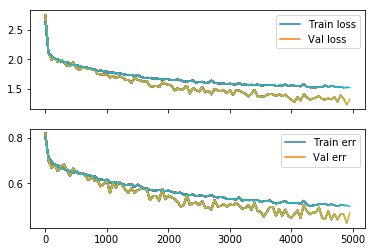

In [16]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
for module in model.children():
    module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
    train_loss, train_err = train_step()
    if step % num_steps_per_val == 0:
        val_loss, val_err = val()
        if val_err < best_val_err:
            best_val_err = val_err
            print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
        info.append([step, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])

In [17]:
torch.save(model.state_dict(), "metadata.model")

## Again, but with features

In [18]:
# Load features.
features = load('fma_metadata/features.csv')

#### Features

What exactly are features? fine out [here](https://github.com/mdeff/fma#Data). There are a lot of features for each track. For now we will keep them all. There are no NaNs in this table. So we can keep this data as is for now.

In [19]:
features_ = features.copy()
ipd.display(features.head(5))
features_.columns = range(0, features.shape[1])
features_.columns = pd.MultiIndex.from_product([['features'], features_.columns])
ipd.display(features_.head(5))

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                               ...      tonnetz  \
statistics                                            ...          std   
number            07        08        09        10    ...           04   
track_id                                              ...                
2           1.481593  2.691455  0.866868  1.341231    ...     0.054125   
3           1.366848  1.054094  0.108103  0.619185    ...     0.063831   
5          -0.923192 -0.927232  0.666617  1.038546    ...     0.040730   
10          1.770694  1.604566  0.521217  1.982386    ...     0.074358   
20         -0.289294 -0.816410  0.043851 -0.804761    ...     0.095003   

feature                               zcr                                \
statistics                       kurtosis       max      mean    median   
number            05        06         01        01        01        01   
track_id                                                                  
2           0.012226  0.012111   5.758890  0.459473  0.085629  0.071289   
3           0.014212  0.017740   2.824694  0.466309  0.084578  0.063965   
5           0.012691  0.014759   6.808415  0.375000  0.053114  0.041504   
10          0.017952  0.013921  21.434212  0.452148  0.077515  0.071777   
20          0.022492  0.021355  16.669037  0.469727  0.047225  0.040039   

feature                                   
statistics       min      skew       std  
number            01        01        01  
track_id                                  
2           0.000000  2.089872  0.061448  
3           0.000000  1.716724  0.069330  
5           0.000000  2.193303  0.044861  
10          0.000000  3.542325  0.040800  
20          0.000977  3.189831  0.030993  

[5 rows x 518 columns]

features                                                    \
               0         1         2         3         4         5     
track_id                                                               
2         7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3         1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5         0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10        3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20       -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

                                                    ...               \
               6         7         8         9      ...          508   
track_id                                            ...                
2         1.481593  2.691455  0.866868  1.341231    ...     0.054125   
3         1.366848  1.054094  0.108103  0.619185    ...     0.063831   
5        -0.923192 -0.927232  0.666617  1.038546    ...     0.040730   
10        1.770694  1.604566  0.521217  1.982386    ...     0.074358   
20       -0.289294 -0.816410  0.043851 -0.804761    ...     0.095003   

                                                                       \
               509       510        511       512       513       514   
track_id                                                                
2         0.012226  0.012111   5.758890  0.459473  0.085629  0.071289   
3         0.014212  0.017740   2.824694  0.466309  0.084578  0.063965   
5         0.012691  0.014759   6.808415  0.375000  0.053114  0.041504   
10        0.017952  0.013921  21.434212  0.452148  0.077515  0.071777   
20        0.022492  0.021355  16.669037  0.469727  0.047225  0.040039   

                                        
               515       516       517  
track_id                                
2         0.000000  2.089872  0.061448  
3         0.000000  1.716724  0.069330  
5         0.000000  2.193303  0.044861  
10        0.000000  3.542325  0.040800  
20        0.000977  3.189831  0.030993  

[5 rows x 518 columns]

In [20]:
# select out the columns we want
tracks_ = tracks.iloc[:, [1, 7, 21, 23, 37, 41, 43, 46]]
tracks_ = tracks_.join(features_)

# fill nill longitudes and latitudes, then drop all other NaNs
tracks_ = tracks_[tracks_['album']['listens'] != -1]
tracks_.columns = tracks_.columns.droplevel(-2)
tracks_[['latitude', 'longitude']] = tracks_[['latitude', 'longitude']].fillna(value=0)
tracks_.dropna()

tracks_['date_created'] = tracks_['date_created'].map(dateToInt)

tracks_['genres_all'] = tracks_['genres_all'].map(oldGenresToNewGenres)
tracks_ = tracks_[tracks_['genres_all'] != 0]

labels_ = tracks_['genres_all'] - 1
tracks_ = tracks_.drop(columns=['genres_all'])

ipd.display(tracks_.head(5))
ipd.display(labels_.head(5))

,date_created,listens,latitude,longitude,duration,interest,listens,0,1,2,...,508,509,510,511,512,513,514,515,516,517
track_id,,,,,,,,,,,,,,,,,,,,,
2,1.227664e+09,6073,40.058324,-74.405661,168,4656,1293,7.180653,5.230309,0.249321,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,1.227664e+09,6073,40.058324,-74.405661,237,1470,514,1.888963,0.760539,0.345297,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,1.227664e+09,6073,40.058324,-74.405661,206,1933,1151,0.527563,-0.077654,-0.279610,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,1.227664e+09,47632,0.000000,0.000000,161,54881,50135,3.702245,-0.291193,2.196742,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,1.227664e+09,2710,51.895927,0.891874,311,978,361,-0.193837,-0.198527,0.201546,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


track_id
2     13
3     13
5     13
10     6
20    11
Name: genres_all, dtype: int64

#### PCA
There are 525 features now! There's no way all of these are useful. Let's use PCA to reduce the number of trainable features. I chose 100 arbitrarily, but through guess and check.

In [21]:
data = normalize_stats(tracks_.values)

pca = PCA(n_components=100)
pca.fit(data)
data_ = pca.fit_transform(data)

In [22]:
labels = labels_.values.astype(np.float)

# shuffle the data
idx = np.random.permutation(len(data))
data, labels = data[idx], labels[idx]

train_data = data[:80000, :]
train_labels = labels[:80000]

val_data = data[80000:, :]
val_labels = labels[80000:]

In [23]:
class netWithFeatures(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(data.shape[1] , 200)
        self.l2 = torch.nn.Linear(200, 100)
        self.l5 = torch.nn.Linear(100, 50)
        self.l6 = torch.nn.Linear(50, 16)
        self.d1 = torch.nn.Dropout(.4)

    def forward(self, x):
        x = self.d1(F.relu(self.l1(x)))
        x = self.d1(F.relu(self.l2(x)))
        x = F.relu(self.l5(x))
        x = self.l6(x)

        return x

model = netWithFeatures()

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Step     0: Obtained a best validation error of 0.741.
Step    50: Obtained a best validation error of 0.572.
Step   100: Obtained a best validation error of 0.549.
Step   150: Obtained a best validation error of 0.539.
Step   200: Obtained a best validation error of 0.537.
Step   250: Obtained a best validation error of 0.529.
Step   350: Obtained a best validation error of 0.529.
Step   400: Obtained a best validation error of 0.524.
Step   500: Obtained a best validation error of 0.523.
Step   550: Obtained a best validation error of 0.520.
Step   600: Obtained a best validation error of 0.520.
Step   650: Obtained a best validation error of 0.517.
Step   700: Obtained a best validation error of 0.517.
Step   750: Obtained a best validation error of 0.515.
Step  1000: Obtained a best validation error of 0.510.
Step  1050: Obtained a best validation error of 0.509.
Step  1150: Obtained a best validation error of 0.507.
Step  1200: Obtained a best validation error of 0.507.
Step  1400

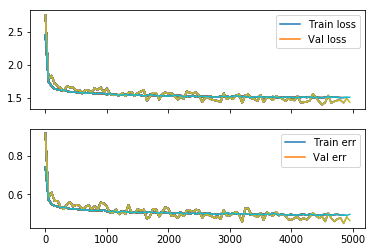

In [25]:
info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
    train_loss, train_err = train_step()
    if step % num_steps_per_val == 0:
        val_loss, val_err = val()
        if val_err < best_val_err:
            best_val_err = val_err
            print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
        info.append([step, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])